0 of 531441
1000 of 531441
2000 of 531441
3000 of 531441
4000 of 531441
5000 of 531441
6000 of 531441
7000 of 531441
8000 of 531441
9000 of 531441
10000 of 531441
11000 of 531441
12000 of 531441
13000 of 531441
14000 of 531441
15000 of 531441
16000 of 531441
17000 of 531441
18000 of 531441
19000 of 531441
20000 of 531441
21000 of 531441
22000 of 531441
23000 of 531441
24000 of 531441
25000 of 531441
26000 of 531441
27000 of 531441
28000 of 531441
29000 of 531441
30000 of 531441
31000 of 531441
32000 of 531441
33000 of 531441
34000 of 531441
35000 of 531441
36000 of 531441
37000 of 531441
38000 of 531441
39000 of 531441
40000 of 531441
41000 of 531441
42000 of 531441
43000 of 531441
44000 of 531441
45000 of 531441
46000 of 531441
47000 of 531441
48000 of 531441
49000 of 531441
50000 of 531441
51000 of 531441
52000 of 531441
53000 of 531441
54000 of 531441
55000 of 531441
56000 of 531441
57000 of 531441
58000 of 531441
59000 of 531441
60000 of 531441
61000 of 531441
62000 of 531441
63000

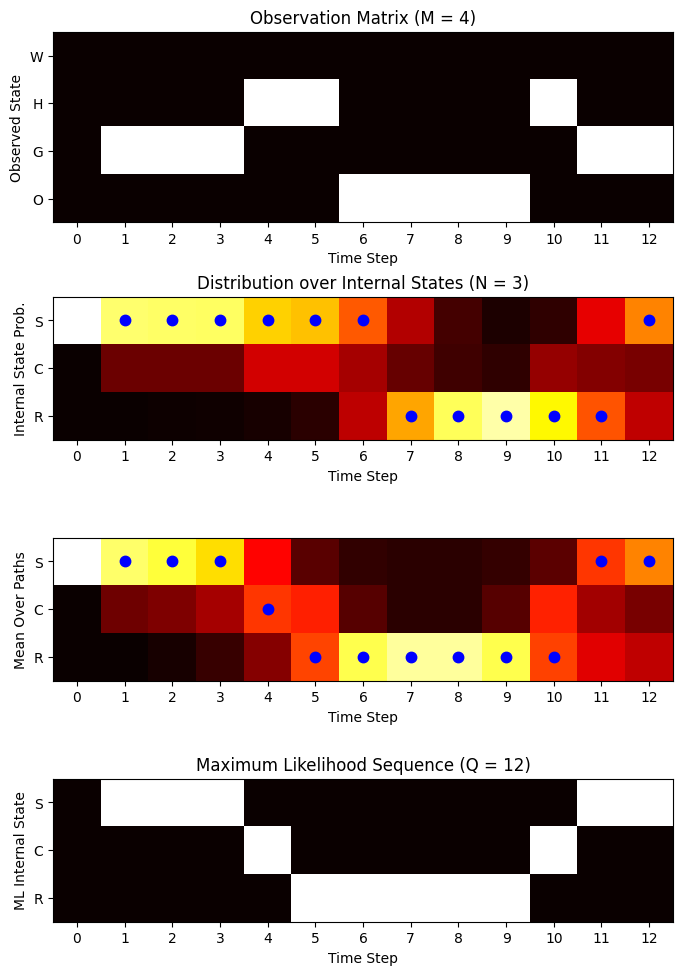

In [9]:
# Tristan Ursell
# HMM Toy Model
# May 2024
#
# This code is intended to be 'simple', in the sense that it does not rely on dynamic programming.  
# The downside is that for any observed sequence of length greater than ~15-20, the computation time becomes prohibitive.
#

import numpy as np
import matplotlib.pyplot as plt

# Transition matrix (Weather, internal state: S, C, R)
P = np.array([
    [0.7, 0.3, 0],
    [0.6, 0.3, 0.1],
    [0, 0.2, 0.8]
])
'''
P = np.array([
    [0.9, 0.1, 0],
    [0.1, 0.5, 0.4],
    [0, 0.3, 0.7]
])
'''

# Emission matrix (Activity, external state: W, H, G, O)
E = np.array([
    [0.2, 0.2, 0.5, 0.1],
    [0.5, 0.2, 0.2, 0.1],
    [0.1, 0.2, 0.2, 0.5]
])

# Number of states and observations
N, M = E.shape

# Compute stationary state
Pinf = np.linalg.matrix_power(P, 100000)
x_star = Pinf[0, :]

# Initial condition
x0 = np.array([1, 0, 0])

# Observation sequence(s)
#obsv_temp = np.array([1, 1, 1, 1])
#obsv_temp = np.array([2, 2, 2, 2])
#obsv_temp = np.array([3, 3, 3, 3])
#obsv_temp = np.array([4, 4, 4, 4])
obsv_temp = np.array([3, 3, 3, 2, 2, 4, 4, 4, 4, 2, 3, 3])
#obsv_temp = np.array([3, 3, 3, 3, 3, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3])
#obsv_temp = np.array([1, 3, 4, 4, 4, 2, 3, 3, 3, 2, 1, 4, 3, 1, 2, 1, 1]) 
#obsv_temp = np.array([1, 1, 1, 4, 4, 4, 3, 3, 3, 2, 1, 4, 3, 1, 2, 1, 4]) 
#obsv_temp = np.array([3, 3, 3, 4, 4, 4, 1, 1, 1, 3, 3, 4, 1, 1, 3, 3, 2]) 

# Sequence length
Q = len(obsv_temp)

# Perform compute-time check
if N**Q>1e6:
    print(f'The search space has {N**Q} sequences, which is a lot.')


if N**Q > 5e8:
    raise ValueError('Too many sequences, reduce sequence length.')


# Compute observation matrix
obsv_mat = np.zeros((M, Q))
for i in range(Q):
    obsv_mat[obsv_temp[i] - 1, i] = 1

# Compute sequence likelihoods
like_vec = np.zeros(N ** Q)

# Generate all possible state sequences
state_sequences = np.array(np.meshgrid(*[np.arange(N) for _ in range(Q)])).T.reshape(-1, Q)

for i, seq_temp in enumerate(state_sequences):
    like_temp = 1
    for k in range(Q):
        int_now = np.eye(N)[:, seq_temp[k]]
        term1 = int_now.T @ E @ obsv_mat[:, k]
        if k == 0:
            term2 = x0.T @ P @ int_now
        else:
            term2 = np.eye(N)[:, seq_temp[k - 1]].T @ P @ int_now
        like_temp *= term1 * term2
    like_vec[i] = like_temp

    if i % 1000 == 0:
        print(f"{i} of {N ** Q}")

# Normalize likelihoods
prob_vec = like_vec / np.sum(like_vec)

# Find best sequence
best_seq = state_sequences[np.argmax(prob_vec)]

# Compute weighted mean path
mean_path = np.zeros((N, Q + 1))
for i, seq_temp in enumerate(state_sequences):
    int_now = np.zeros((N, Q))
    for k in range(Q):
        int_now[seq_temp[k], k] = 1
    mean_path[:, 1:Q + 1] += prob_vec[i] * int_now
mean_path[:, 0] = x0

# Compute state distribution
state_vec = np.zeros((N, Q + 1))
state_vec[:, 0] = x0
for i in range(1, Q + 1):
    evolve_once = P.T @ state_vec[:, i - 1]
    X_mat = evolve_once[:, None] * np.ones((1, M))
    C_mat_raw = E * X_mat
    C_mat_norm = C_mat_raw / np.sum(C_mat_raw, axis=0)
    state_vec[:, i] = C_mat_norm @ obsv_mat[:, i - 1]

# Plot results
plt.figure(figsize=(8, 12))
plt.subplot(4, 1, 1)
plt.imshow(np.hstack([np.zeros((M, 1)), obsv_mat[:, :Q]]), cmap='hot', aspect='equal')
plt.xlabel('Time Step')
plt.ylabel('Observed State')
plt.title(f'Observation Matrix (M = {M})')
plt.xticks(range(Q + 1), range(Q + 1))
plt.yticks(range(E.shape[1]), ['W','H','G','O'])
plt.box(True)

plt.subplot(4, 1, 2)
plt.imshow(state_vec, cmap='hot', aspect='equal', vmin=0, vmax=1)
plt.title(f'Distribution over Internal States (N = {N})')
plt.xlabel('Time Step')
plt.ylabel('Internal State Prob.')
plt.xticks(range(Q + 1), range(Q + 1))
plt.yticks(range(E.shape[0]), ['S','C','R'])
plt.box(True)
for i in range(Q):
    plt.plot(i + 1, np.argmax(state_vec[:, i + 1]), 'b.', markersize=15)

plt.subplot(4, 1, 3)
plt.imshow(mean_path, cmap='hot', aspect='equal', vmin=0, vmax=1)
plt.xlabel('Time Step')
plt.ylabel('Mean Over Paths')
plt.xticks(range(Q + 1), range(Q + 1))
plt.yticks(range(E.shape[0]), ['S','C','R'])
plt.box(True)
for i in range(Q):
    plt.plot(i + 1, np.argmax(mean_path[:, i + 1]), 'b.', markersize=15)

plt.subplot(4, 1, 4)
best_mat = np.zeros((N, Q))
for i in range(Q):
    best_mat[best_seq[i], i] = 1
plt.imshow(np.hstack([np.zeros((N, 1)), best_mat]), cmap='hot', aspect='equal')
plt.title(f'Maximum Likelihood Sequence (Q = {Q})')
plt.xlabel('Time Step')
plt.ylabel('ML Internal State')
plt.xticks(range(Q + 1), range(Q + 1))
plt.yticks(range(E.shape[0]), ['S','C','R'])
plt.box(True)

plt.savefig(f'hmm_toy_model_outputs_Q-{Q}.svg', format='svg')
plt.show()
